In [1]:
!pip install moviepy torch-geometric torch-scatter==1.2.0 torch-sparse

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.3/388.3 kB 10.3 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 33.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 kB 17.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 48.6 MB/s eta 0:00:0000:0100:01
  Created wheel for torch-scatter: filename=torch_scatter-1.2.0-cp310-cp310-linux_x86_64.whl size=709976 sha256=fdd3e341363dc13bac05995a3f55089297287451031d08c8859f655435167552
  Stored in directory: /root/.cache/pip/wheels/b9/b4/18/de4e04fb70f599f354b87d1559cc8adacb92313def4bffd557
  Created wheel for moviepy: filename=moviepy-1.0.3-py3-none-any.whl size=110730 sha256=72db89b04fcf84d87fa495eb3a7ecd5

In [2]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import KarateClub
from torch_geometric.utils import to_networkx
import networkx as nx

from sklearn.manifold import TSNE
import numpy as np
import os
import io
os.environ["TORCH"]= torch.__version__
from IPython.display import Image
from moviepy.editor import ImageSequenceClip
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
print(torch.__version__)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


2.0.0


In [3]:
# Plot the graph
def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos= nx.spring_layout(G, seed= 42), with_labels= False, node_color= color, cmap= "gist_rainbow_r")
    plt.show()

In [4]:
# Plot node embeddings
def visualize_embedding(h, color, epoch= None, loss= None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h= h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s= 140, c= color, cmap= "gist_rainbow_r")
    if epoch is not None and loss is not None:
        plt.xlabel('Epoch: {}, Loss: {}'.format(epoch, loss.item()), fontsize= 16)
    plt.show()


In [5]:
# Load dataset
dataset= KarateClub()
print("Number of Graphs: ", len(dataset))
print("Number of features: ", dataset.num_features)
print("Number of classes: ", dataset.num_classes)

Number of Graphs:  1
Number of features:  34
Number of classes:  4


In [6]:
# Get the first graph object
data= dataset[0]
print(data)

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])


In [7]:
# Getting statistics about the graph
print("Number of nodes: ", data.num_nodes)
print("Number of edges: ", data.num_nodes)
print("Average node degree: ", data.num_edges/data.num_nodes)
print("Number of training nodes: ", data.train_mask.sum())
print("Has self loops?: ", data.has_self_loops())
print("Is undirected?: ", data.is_undirected())

Number of nodes:  34
Number of edges:  34
Average node degree:  4.588235294117647
Number of training nodes:  tensor(4)
Has self loops?:  False
Is undirected?:  True


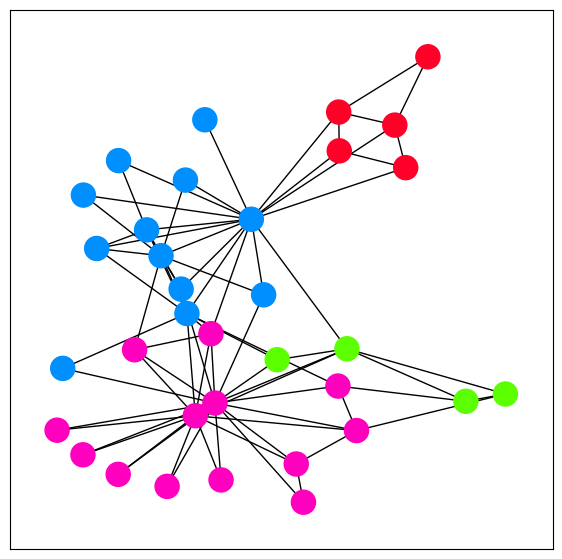

In [8]:
# Plot the graph object
G= to_networkx(data, to_undirected= True)
visualize_graph(G, color= data.y)

In [9]:
edge_index= data.edge_index
print(edge_index.t())

tensor([[ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0, 10],
        [ 0, 11],
        [ 0, 12],
        [ 0, 13],
        [ 0, 17],
        [ 0, 19],
        [ 0, 21],
        [ 0, 31],
        [ 1,  0],
        [ 1,  2],
        [ 1,  3],
        [ 1,  7],
        [ 1, 13],
        [ 1, 17],
        [ 1, 19],
        [ 1, 21],
        [ 1, 30],
        [ 2,  0],
        [ 2,  1],
        [ 2,  3],
        [ 2,  7],
        [ 2,  8],
        [ 2,  9],
        [ 2, 13],
        [ 2, 27],
        [ 2, 28],
        [ 2, 32],
        [ 3,  0],
        [ 3,  1],
        [ 3,  2],
        [ 3,  7],
        [ 3, 12],
        [ 3, 13],
        [ 4,  0],
        [ 4,  6],
        [ 4, 10],
        [ 5,  0],
        [ 5,  6],
        [ 5, 10],
        [ 5, 16],
        [ 6,  0],
        [ 6,  4],
        [ 6,  5],
        [ 6, 16],
        [ 7,  0],
        [ 7,  1],
        [ 7,  2],
        [ 

In [10]:
# Build GCN
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(906)
        self.conv1= GCNConv(dataset.num_features, 4)
        self.conv2= GCNConv(4,4)
        self.conv3= GCNConv(4,2)
        self.classifier= Linear(2, dataset.num_classes)
        
    def forward(self, x, edge_index):
        h= self.conv1(x, edge_index)
        h= h.tanh()
        h= self.conv2(h, edge_index)
        h= h.tanh()
        h= self.conv3(h, edge_index)
        h= h.tanh()
        
        out= self.classifier(h)
        
        return out, h


In [11]:
# Visualize the Output
def plt2arr(fig):
    rgb_str = fig.canvas.tostring_rgb()
    (w,h) = fig.canvas.get_width_height()
    rgba_arr = np.fromstring(rgb_str, dtype=np.uint8, sep='').reshape((w,h,-1))
    return rgba_arr


def visualize(h, color, epoch, loss):
    fig = plt.figure(figsize=(5,5), frameon=False)
    fig.suptitle('Epoch: {} Loss: {}'.format(epoch, loss))
    # Fit TSNE with 2 components
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    # Create scatterplot from embeddings
    plt.xticks([])
    plt.yticks([])
    plt.scatter(z[:, 0], 
                z[:, 1], 
                s=70, 
                c=color.detach().cpu().numpy(), 
                cmap="gist_rainbow_r")
    
    fig.canvas.draw();
    plt.ioff()
    # Convert to numpy
    return plt2arr(fig)

In [12]:
# Embedding the dataset
model= GCN()
_,h= model(data.x, data.edge_index)
print("Embedding shape:", list(h.shape))

Embedding shape: [34, 2]


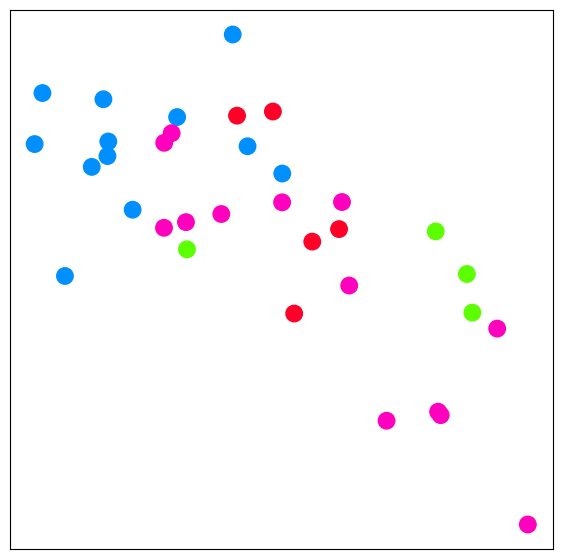

In [13]:
visualize_embedding(h, color= data.y)

In [14]:
# Training the model
criterion= torch.nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(model.parameters())

def train(data):
    optimizer.zero_grad()
    out, h= model(data.x, data.edge_index)
    loss= criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss, h

In [ ]:
model_loss= []
images= []
for epoch in range(2001):
    loss, h= train(data)
    model_loss.append(loss)     
    if epoch%100==0:
        print("Epoch: {}, Loss: {}".format(epoch, loss))
        images.append(visualize(h, color= data.y, epoch= epoch, loss= loss))

Epoch: 0, Loss: 1.4082796573638916 <br>
Epoch: 100, Loss: 1.2432024478912354<br>
Epoch: 200, Loss: 0.9507966637611389<br>
Epoch: 300, Loss: 0.6688352227210999<br>
Epoch: 400, Loss: 0.4781849682331085<br>
Epoch: 500, Loss: 0.36086538434028625<br>
Epoch: 600, Loss: 0.28594642877578735<br>
Epoch: 700, Loss: 0.2348974496126175<br>
Epoch: 800, Loss: 0.19802838563919067<br>
Epoch: 900, Loss: 0.1701347976922989<br>
Epoch: 1000, Loss: 0.14826616644859314<br>
Epoch: 1100, Loss: 0.1306471973657608<br>
Epoch: 1200, Loss: 0.11614816635847092<br>
Epoch: 1300, Loss: 0.10401368141174316<br>
Epoch: 1400, Loss: 0.0937177985906601<br>
Epoch: 1500, Loss: 0.08488203585147858<br>
Epoch: 1600, Loss: 0.07722597569227219<br>
Epoch: 1700, Loss: 0.07053707540035248<br>
Epoch: 1800, Loss: 0.06465102732181549<br>
Epoch: 1900, Loss: 0.05943872407078743<br>
Epoch: 2000, Loss: 0.05479725822806358<br>

MoviePy - Building file Embeddings.gif with imageio.


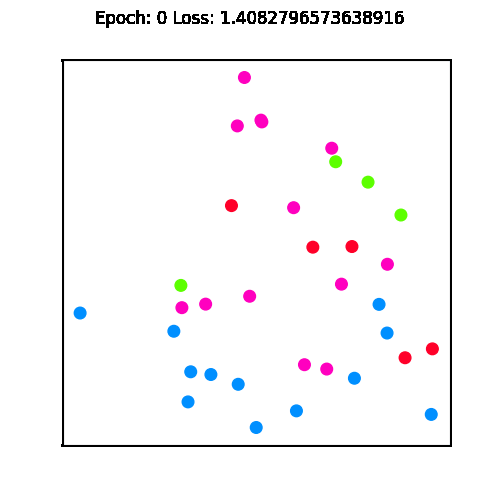

In [16]:
filename= "Embeddings.gif"
clip= ImageSequenceClip(images, fps= 0.001)
clip.write_gif(filename, fps= 0.001)
with open('/kaggle/working/Embeddings.gif', 'rb') as f:
    display(Image(data= f.read(), format= 'png'))